In [1]:
# are the future functions actually necessary?
from __future__ import absolute_import, division, print_function, unicode_literals
import imp

from data_read import read_paths
from pathData import PathData
from snapData import SnapData
from datasetData import DatasetData
from plotData import PlotData
from importanceData import ImportanceData
from globalConstants import Const
from autoEncoder import AutoEncoder 
from stepwiseData import StepwiseData
from gridData import GridData
#from data_plot import map_generated

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)
# allows for automatic reloading of imports and makes it unncessecary to restart the kernel
# whenever a function is changed
%load_ext autoreload
%autoreload 2

In [2]:
c = Const()
#used_vars = [0, 1, 7, 8, 9]
#used_vars = [0, 1, 7, 8, 9, 10, 11, 13, 3]
#used_vars = [0, 2, 5, 6, 7, 8, 9, 11, 13, 17, 18, 19, 20, 21]
used_vars = [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 
    12, 13, 14, 15, 16, 17, 18, 19, 20, 21
    ]
var_names = c.used_names(used_vars)
var_order = c.used_order(used_vars)
print(var_names)
print(var_order)


{0: 'MCG', 1: 'N_{w,4}', 2: 'N_{w,3}', 3: 'N_{w,2}', 4: 'N_{sw,3-4}', 5: 'N_{sw,2-3}', 6: 'F4', 7: 'R_g', 8: '5^{12}6^{2}', 9: '5^{12}', 10: 'CR', 11: 'N_{s,2}', 12: 'N_{s,3}', 13: 'N_{c,2}', 14: 'N_{c,3}', 15: 'N_{s,4}', 16: 'N_{c,4}', 17: '5^{12}6^{3}', 18: '5^{12}6^{4}', 19: '4^{1}5^{10}6^{2}', 20: '4^{1}5^{10}6^{3}', 21: '4^{1}5^{10}6^{4}'}
[0, 11, 12, 15, 13, 14, 16, 3, 2, 1, 5, 4, 9, 8, 17, 18, 19, 20, 21, 10, 7, 6]


In [3]:
pathO = PathData(
    *read_paths(
        c.folder_name, 
        c.mcg_A, 
        c.mcg_B,
        used_vars), 
    c.path_type_labels, 
    c.path_type_weights)

mcg100
mcg30
3328.0
1.0


In [4]:
snapO = SnapData(
    *pathO.snapshots_labels_weights(
        offset = c.offset, 
        progress = c.progress, 
        transitioned = c.transitioned, 
        turnedback = c.turnedback))

1.0
1082141.0 114988.0
598564.5000018578 598564.5000007054


In [5]:
dataO = DatasetData(
    *snapO.split_lists(c.train_ratio, c.val_ratio), 
    outlier_cutoff = c.outlier_cutoff)

In [6]:
gridO = GridData(*dataO.plot_data(), c.resolution)


In [51]:
print(str(gridO))
 
train_grid_snapshots = gridO.gridify_snapshots(dataO.train_norm_snapshots)
val_grid_snapshots = gridO.gridify_snapshots(dataO.val_norm_snapshots)

22-dimensional 15-grid for 718277 snapshots.


In [52]:
pB_dict = gridO.approximate_pB(train_grid_snapshots)

Gridify
Fill hash maps
Rescale


In [54]:
#print([*zip([(key, label) for key, label in pB_dict.items()])])
#print([key for key, label in pB_dict.items()])
#print([label for key, label in pB_dict.items()])
trimmed_keys = list(map(list,[key for key, label in pB_dict.items() if label > 0.0 and label < 1.0]))
trimmed_labels = [label for key, label in pB_dict.items() if label > 0.0 and label < 1.0]
trimmed_back_keys = list(map(list,[key for key, label in pB_dict.items() if label < 1.0]))
trimmed_back_labels = [label for key, label in pB_dict.items() if label < 1.0]
print(len(trimmed_keys))
print(len(trimmed_labels))
print(len(trimmed_back_keys))
print(len(trimmed_back_labels))

#print(trimmed_keys[:10])
#print(trimmed_labels[:10])

14291
14291
326726
326726


In [49]:
gridO.plot_distribution(grid_snapshots,6,20,var_names,"untrimmed")
gridO.plot_distribution(trimmed_keys,6,20,var_names,"trimmed_both")
gridO.plot_distribution(trimmed_back_keys,6,20,var_names,"trimmed_back")

356502
1.0
0.0
44067
312435
312581
43921


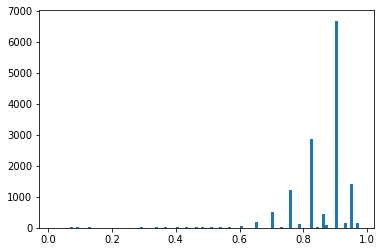

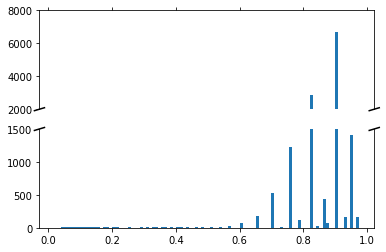

In [45]:
print(len(pB_dict))
print(max([label for key, label in pB_dict.items()]))
print(min([label for key, label in pB_dict.items()]))
print(len([label for key, label in pB_dict.items() if label > 0.0]))
print(len([label for key, label in pB_dict.items() if label == 0.0]))
print(len([label for key, label in pB_dict.items() if label < 0.25]))
print(len([label for key, label in pB_dict.items() if label > 0.25]))
plt.figure()
plt.hist(trimmed_labels, 100)
plt.savefig("trimmed_labels.png")
plt.show()

def broken_hist(xs, bins, y_lower_1, y_upper_1, y_lower_2, y_upper_2, filename):
    f, (ax, ax2) = plt.subplots(2, 1, sharex=True)
    # ax.hist([label for key, label in pB_dict.items()], 100)
    # ax2.hist([label for key, label in pB_dict.items()], 100)
    ax.hist(xs, bins)
    ax2.hist(xs, bins)
    ax.set_ylim(y_lower_2, y_upper_2)  # outliers only
    ax2.set_ylim(y_lower_1, y_upper_1)  # most of the data
    # hide the spines between ax and ax2
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    plt.savefig(filename)
    plt.show()

broken_hist(trimmed_labels, 100, 0, 1500, 2000, 8000, "Hist_scaled_labels.png")


In [46]:
gridO.plot_distribution(trimmed_keys,6,20,var_names,"trimmed")

In [37]:
print(grid_snapshots[:10])

[[ 2  2  2  2  2  2  0 12  1  2  4  2  4  2  2  2  2  0  0  7  0  0]
 [ 5  4  4  5  5  7  5 12  1  1  8  6  8  5  4  8  3  0  0  0  0  0]
 [ 5  4  5  5  5  6  5  4  2  3  5  2  7  6  4  6  4  0  0  0  0  0]
 [ 9  7  8  9  9 10  5 13  4  7  5  8  9  8  8 10  7  5  0  0 14  0]
 [ 3  3  3  3  2  4  9 12  1  4  2  2  3  3  3  3  3  0  0  0  0  0]
 [14 14 14 14 14 14  9 14 14 14  8 12 14 14 14 14 14 14 14  0  0  0]
 [ 2  2  2  2  2  3  9  1  0  2  0  3  2  2  2  3  2  0  0  0  0  0]
 [10  7  9 10 11 12  5  4  5 10  4 11 13 10  9 12  9  5  0  0  0  0]
 [13 14 13 13 12 12  9 13 12 10 12  6  9 14 14 10 14  9  0  0  0  0]
 [ 1  0  1  1  1  1  9  1  0  0  0  2  1  0  0  1  1  0  0  0  0  0]]


In [56]:
# generates the dataset by feeding in a tuple, of dictionaries 
# (alternative would be a tuble of lists)
train_grid_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: trimmed_back_keys}, 
    {c.output_name_1: trimmed_back_labels, 
    c.output_name_2: trimmed_back_keys})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("train_ds generated")
val_grid_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: val_grid_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_labels, 
    c.output_name_2: val_grid_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_weights, 
    c.output_name_2: dataO.val_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("val_ds generated")

train_ds generated
val_ds generated


In [38]:
# generates the dataset by feeding in a tuple, of dictionaries 
# (alternative would be a tuble of lists)
train_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: dataO.train_norm_past_snapshots}, 
    {c.output_name_1: dataO.train_snapshot_labels, 
    c.output_name_2: dataO.train_norm_snapshots}, 
    {c.output_name_1: dataO.train_snapshot_weights, 
    c.output_name_2: dataO.train_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("train_ds generated")
val_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: dataO.val_norm_past_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_labels, 
    c.output_name_2: dataO.val_norm_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_weights, 
    c.output_name_2: dataO.val_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("val_ds generated")


train_ds generated
val_ds generated


In [57]:
modelO = AutoEncoder(c)
(autoencoder, autoencoder_1, autoencoder_2) = \
    modelO.model(dataO.dimensions)

In [58]:
#autoencoder.fit(train_ds_batch,epochs=EPOCHS, class_weight=class_weight)
history = autoencoder.fit(
    train_grid_ds,epochs = c.epochs,  
    validation_data = val_grid_ds)
#history = autoencoder.fit(
#    train_ds,epochs = c.epochs,  
#    validation_data = val_ds)

Train for 5106 steps, validate for 1871 steps
Epoch 1/5
5106/5106 [==============================] - 21s 4ms/step - loss: 4.7452 - label_loss: 0.1493 - reconstruction_loss: 4.5959 - val_loss: 7.7436 - val_label_loss: 1.3684 - val_reconstruction_loss: 6.3752
Epoch 2/5
5106/5106 [==============================] - 19s 4ms/step - loss: 4.7296 - label_loss: 0.1458 - reconstruction_loss: 4.5838 - val_loss: 8.1468 - val_label_loss: 1.7685 - val_reconstruction_loss: 6.3784
Epoch 3/5
5106/5106 [==============================] - 19s 4ms/step - loss: 4.7285 - label_loss: 0.1453 - reconstruction_loss: 4.5833 - val_loss: 7.5097 - val_label_loss: 1.1336 - val_reconstruction_loss: 6.3760
Epoch 4/5
5106/5106 [==============================] - 20s 4ms/step - loss: 4.7278 - label_loss: 0.1448 - reconstruction_loss: 4.5829 - val_loss: 7.3626 - val_label_loss: 0.9854 - val_reconstruction_loss: 6.3772
Epoch 5/5
5106/5106 [==============================] - 19s 4ms/step - loss: 4.7282 - label_loss: 0.1449 - 

In [59]:
print(history.history["val_loss"][-1])

7.327078211313897


In [68]:
#plotO = PlotData(*dataO.plot_data(), c.stamp)
plotO = PlotData(np.zeros(len(used_vars), [trimmed_back_keys, trimmed_back_labels, np.ones(len(trimmed_back_keys)), c.stamp)

TypeError: __init__() missing 2 required positional arguments: 'train_snapshot_weights' and 'stamp'

1: N_{w,2}	0: MCG
2: N_{w,3}	0: MCG
2: N_{w,3}	1: N_{w,2}
3: N_{w,4}	0: MCG
3: N_{w,4}	1: N_{w,2}
3: N_{w,4}	2: N_{w,3}
4: N_{sw,2-3}	0: MCG
4: N_{sw,2-3}	1: N_{w,2}
4: N_{sw,2-3}	2: N_{w,3}
4: N_{sw,2-3}	3: N_{w,4}
5: N_{sw,3-4}	0: MCG
5: N_{sw,3-4}	1: N_{w,2}
5: N_{sw,3-4}	2: N_{w,3}
5: N_{sw,3-4}	3: N_{w,4}
5: N_{sw,3-4}	4: N_{sw,2-3}
0


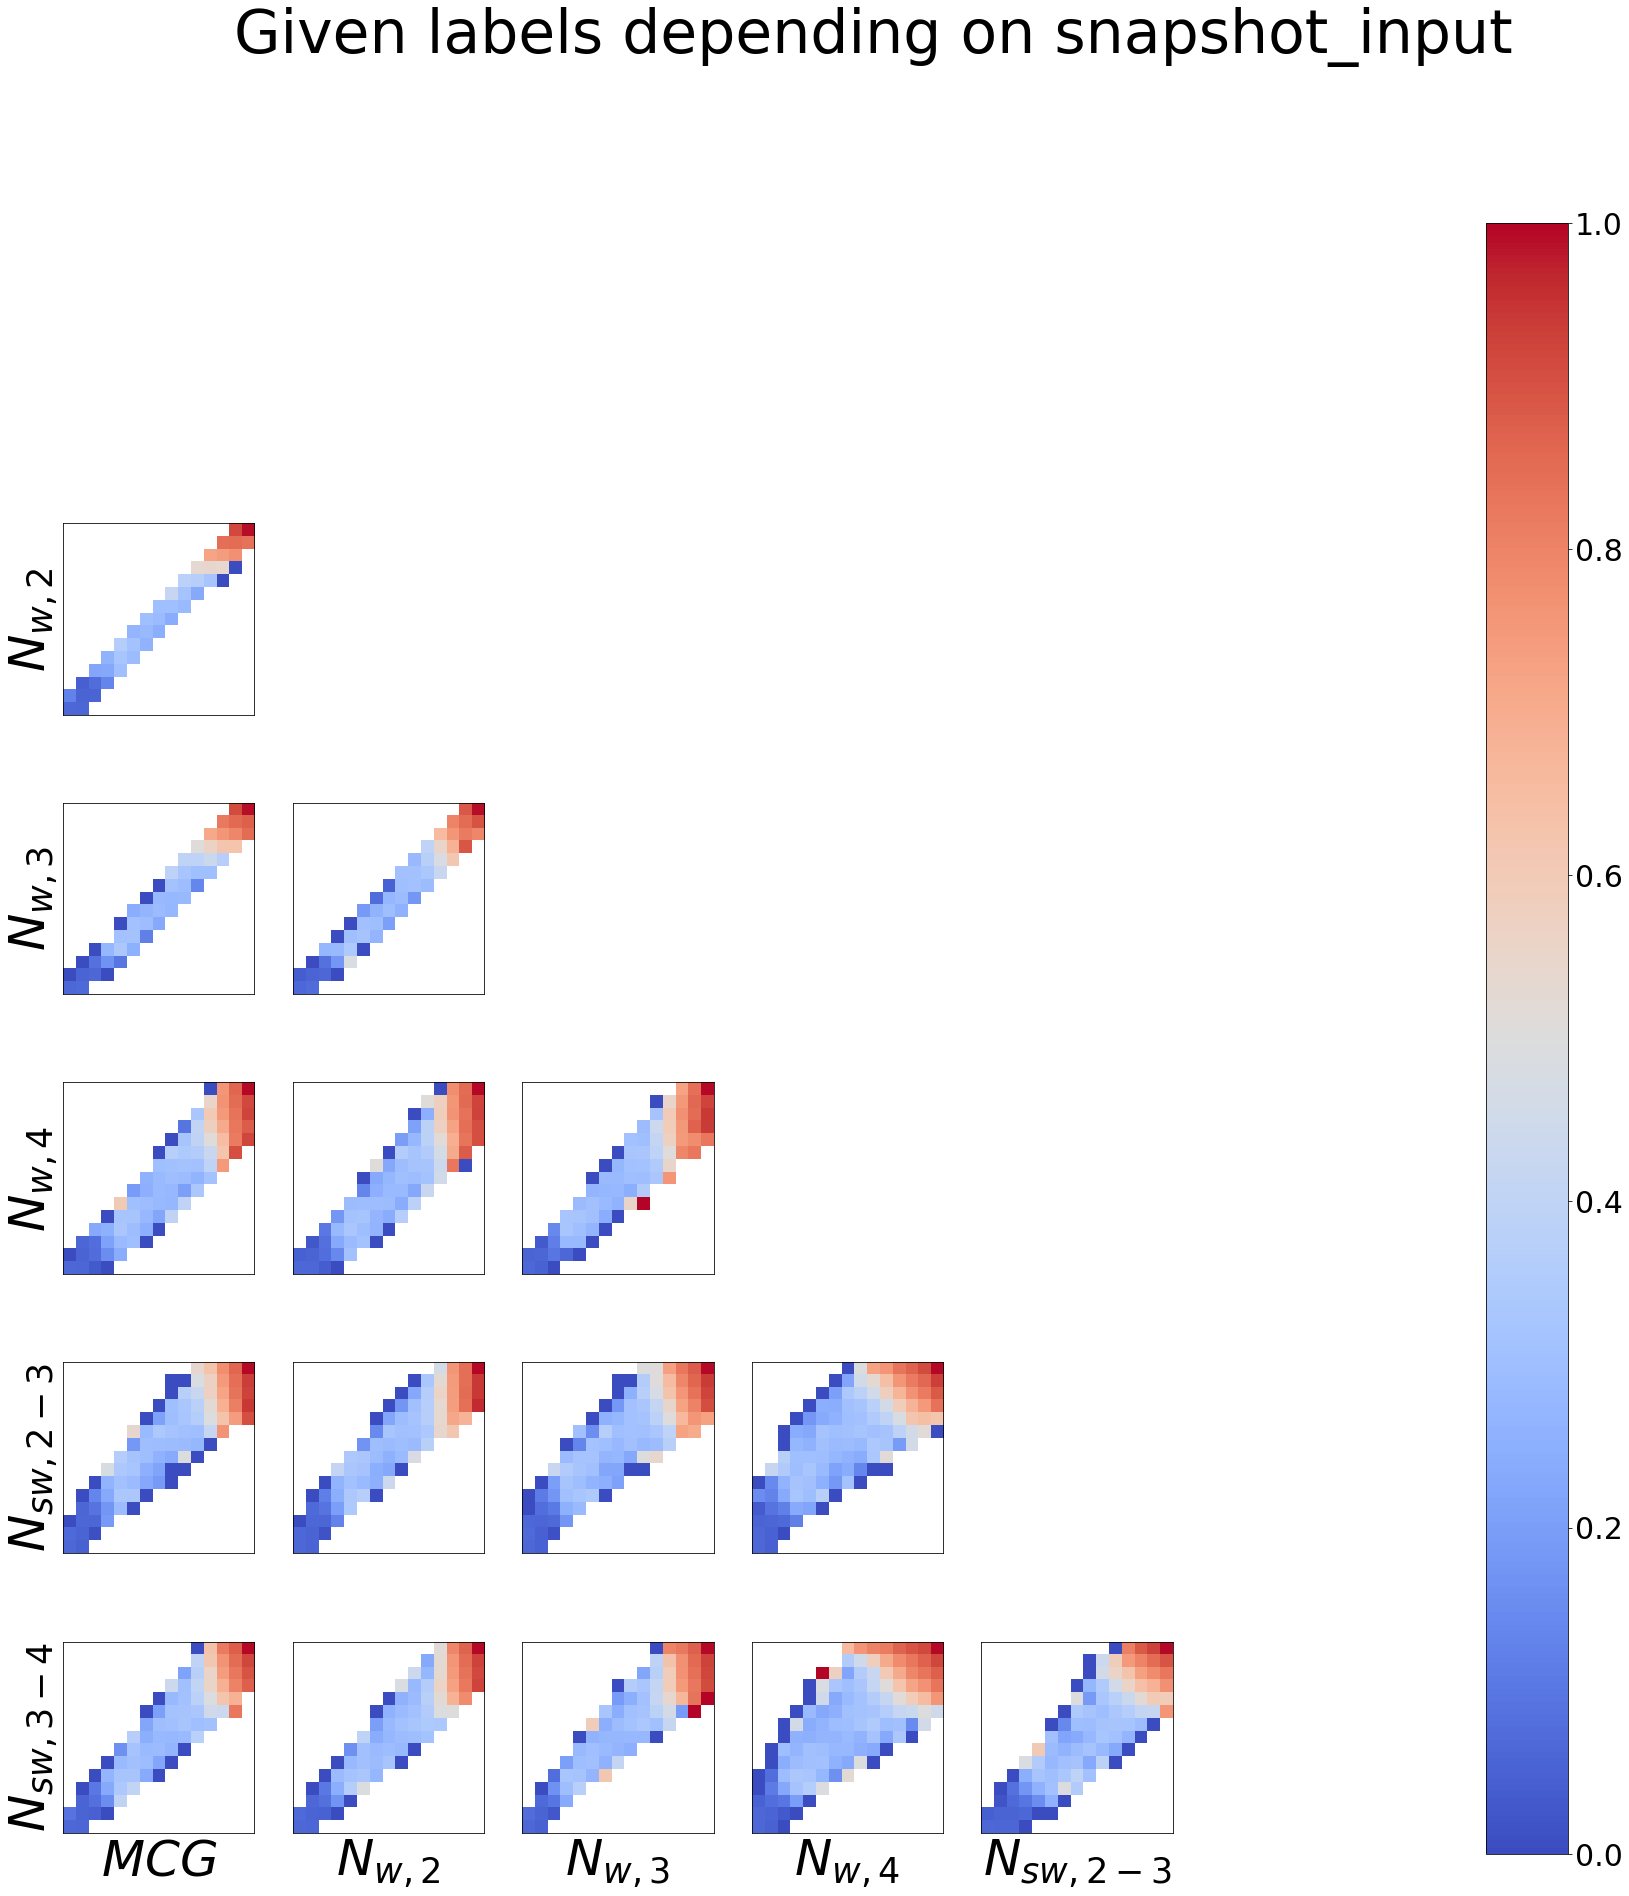

In [63]:
var_names = c.used_names([0,1,2,3,4,5])
var_order = c.used_order([0,1,2,3,4,5])

plotO.plot_super_map(
    subfig_size = c.subfig_size, 
    i_s = var_order, js = var_order, 
    stamp = c.stamp, var_names = var_names, 
    resolution = c.resolution,
    vmin = c.min_label, vmax = c.max_label, model = None, fill_val = 0)
        

pass

1: N_{w,2}	0: MCG
2: N_{w,3}	0: MCG
2: N_{w,3}	1: N_{w,2}
3: N_{w,4}	0: MCG
3: N_{w,4}	1: N_{w,2}
3: N_{w,4}	2: N_{w,3}
4: N_{sw,2-3}	0: MCG
4: N_{sw,2-3}	1: N_{w,2}
4: N_{sw,2-3}	2: N_{w,3}
4: N_{sw,2-3}	3: N_{w,4}
5: N_{sw,3-4}	0: MCG
5: N_{sw,3-4}	1: N_{w,2}
5: N_{sw,3-4}	2: N_{w,3}
5: N_{sw,3-4}	3: N_{w,4}
5: N_{sw,3-4}	4: N_{sw,2-3}
0


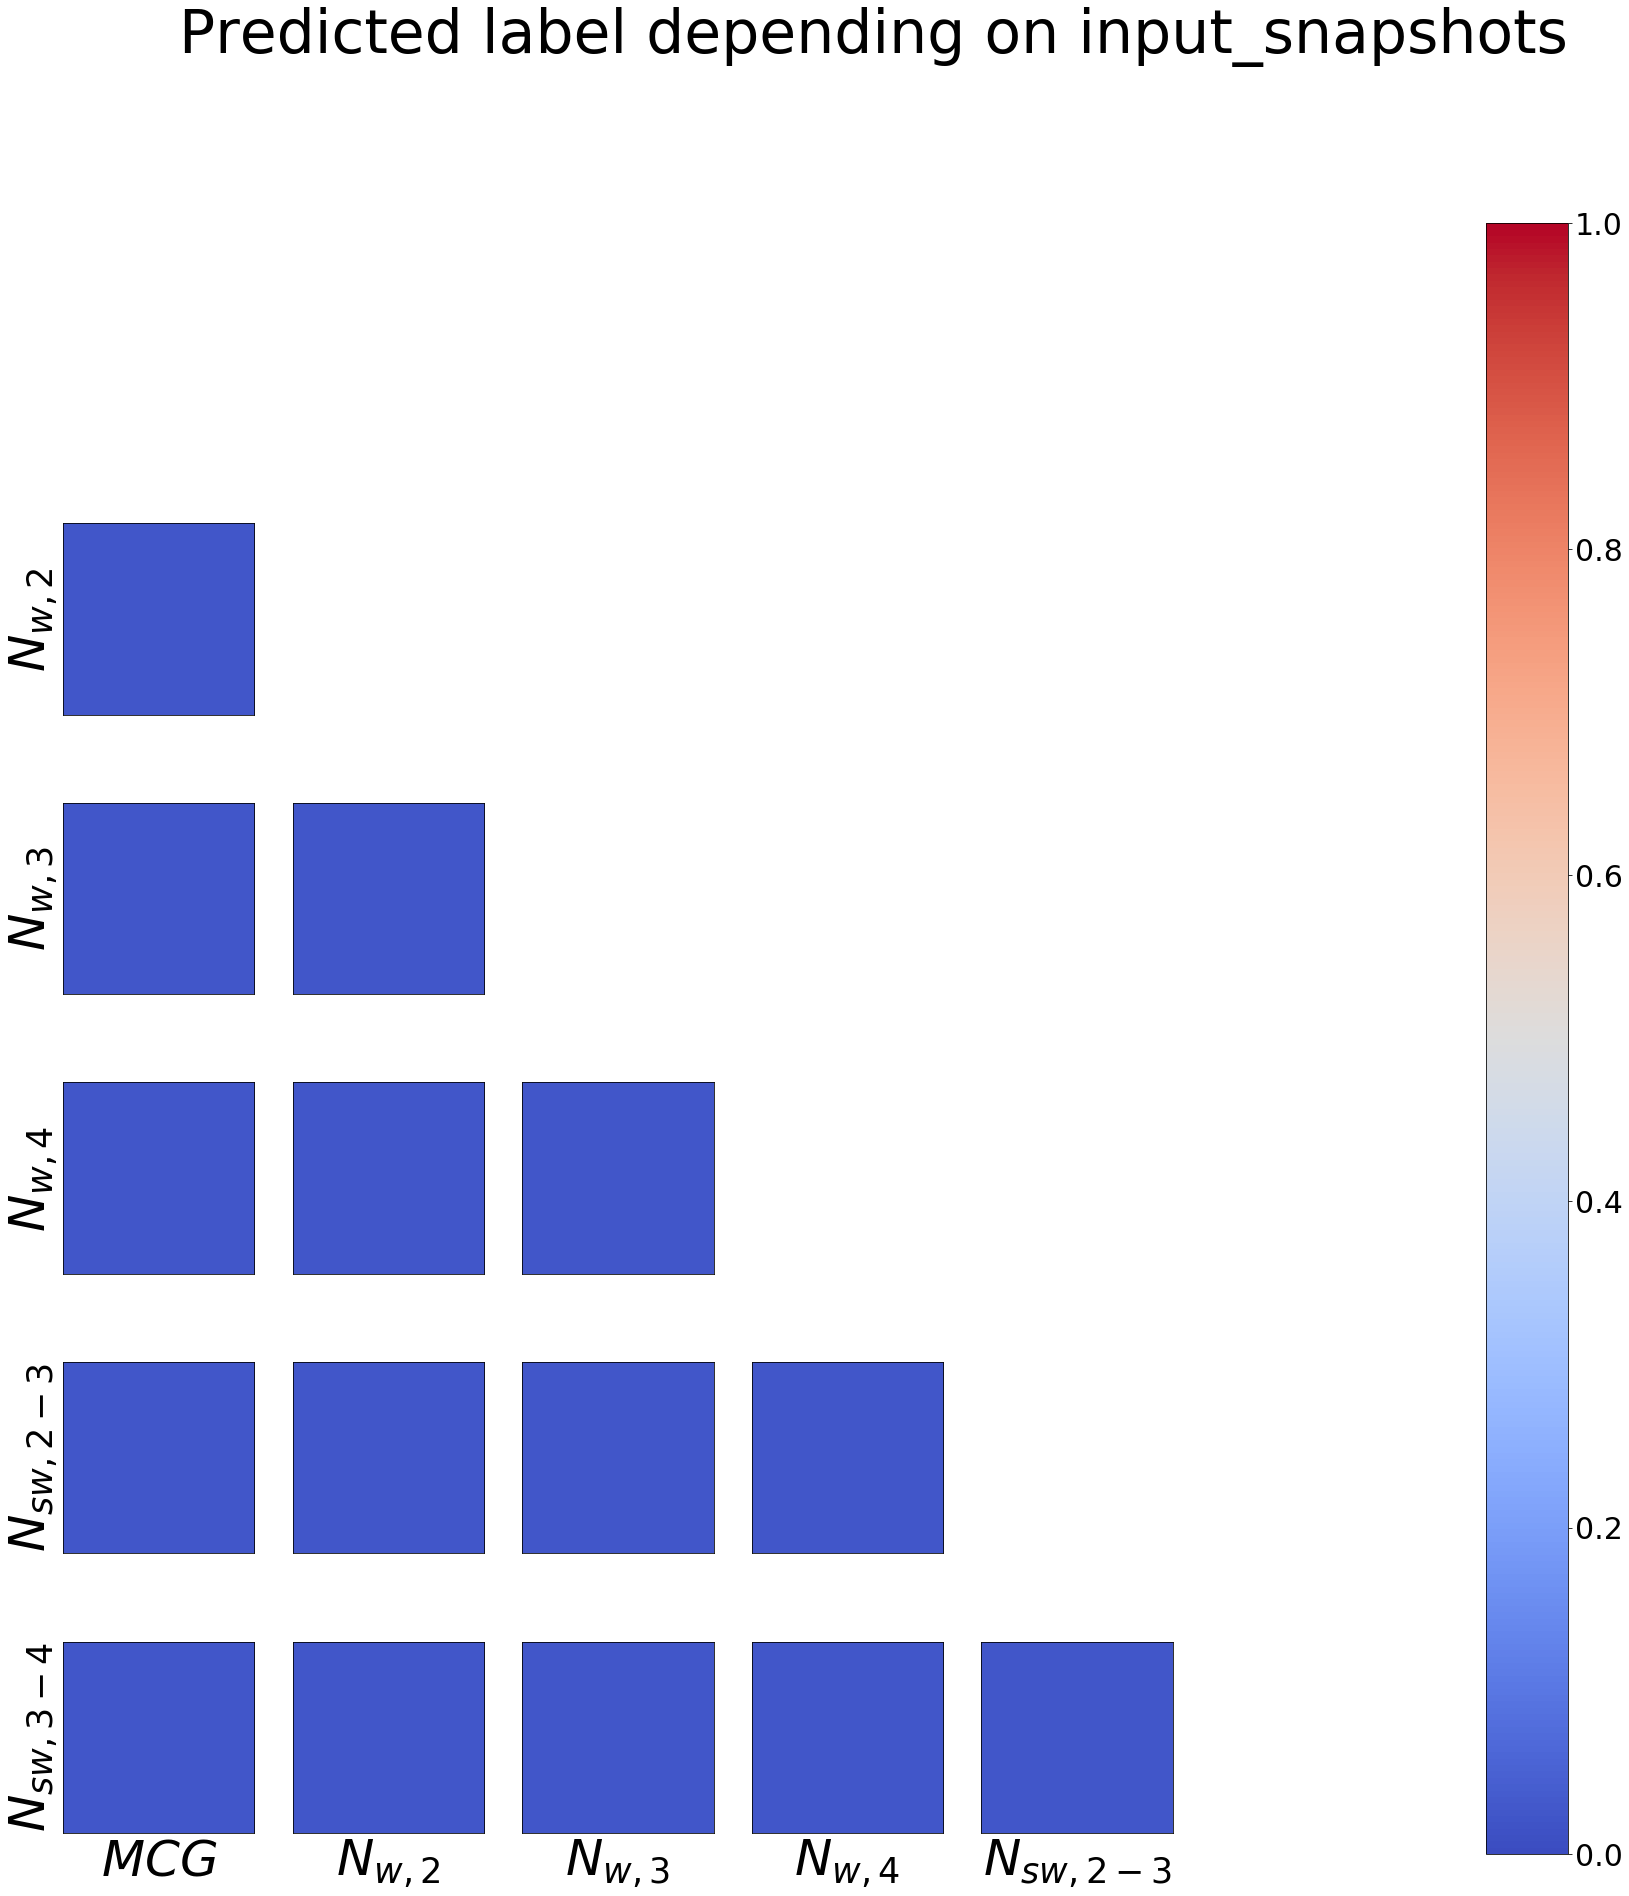

In [64]:
plotO.plot_super_map(
    subfig_size = c.subfig_size, 
    i_s = var_order, js = var_order, 
    stamp = c.stamp, var_names = var_names, 
    resolution = c.resolution, 
    vmin = c.min_label, vmax = c.max_label, 
    model = autoencoder_1, fill_val = 0)
pass

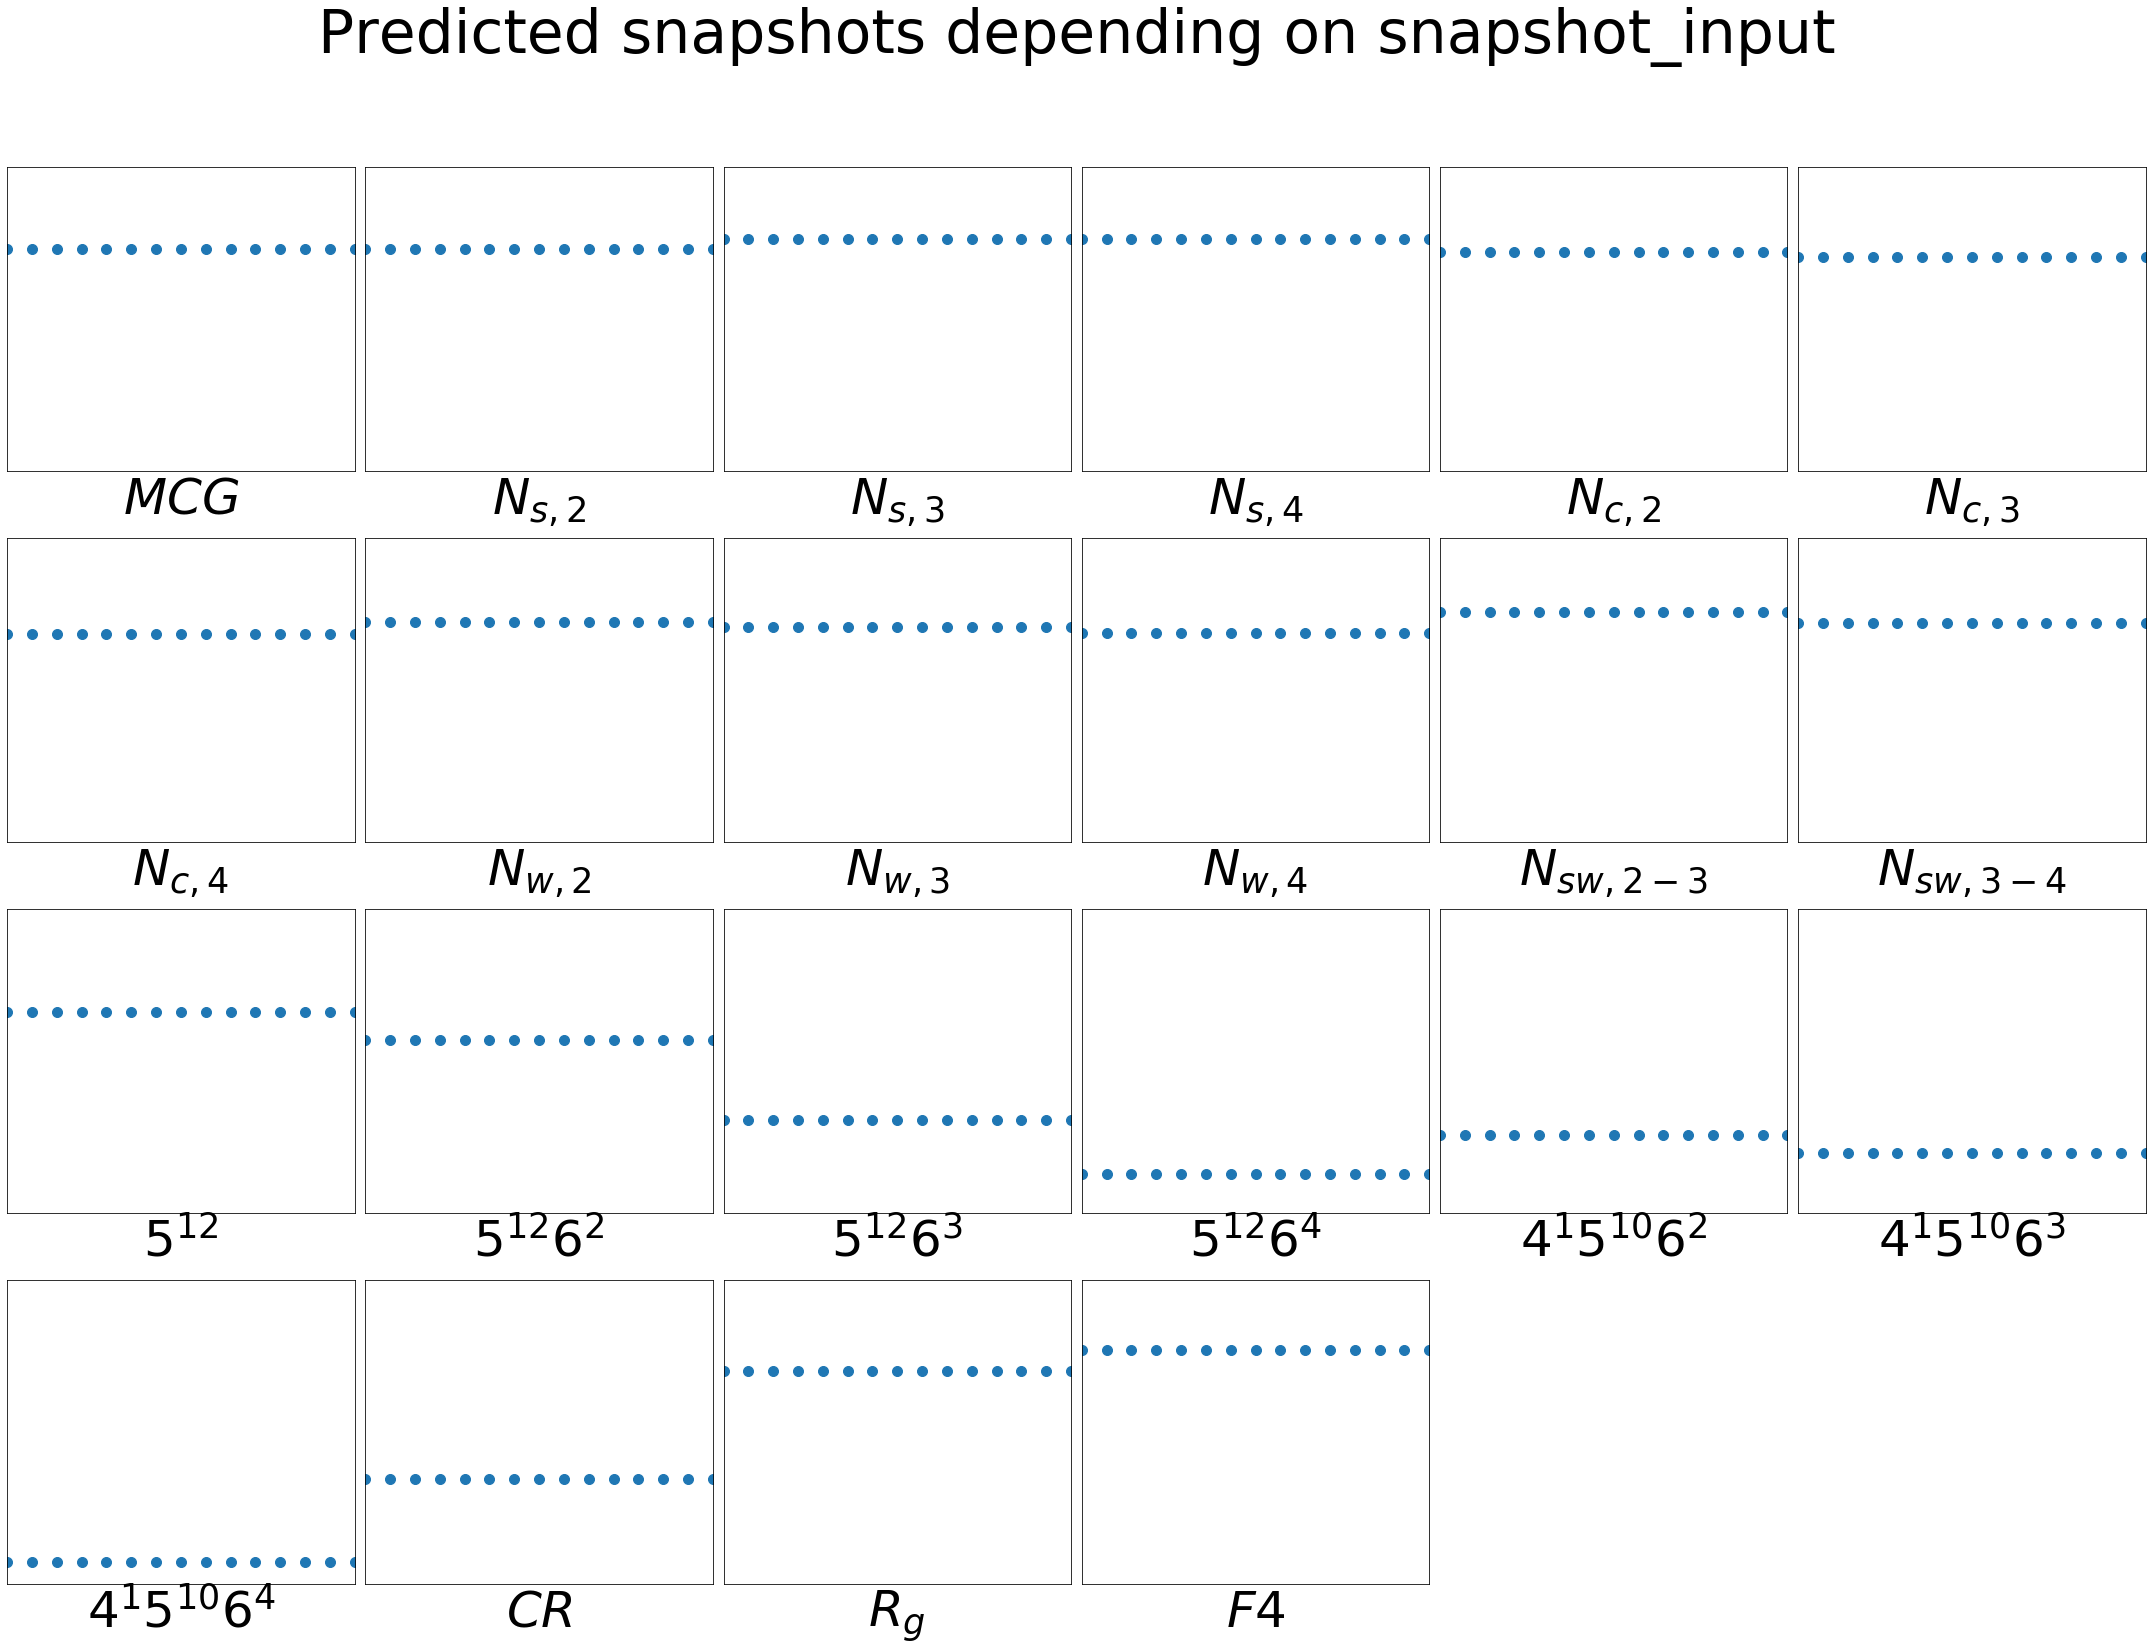

In [62]:
plotO.plot_super_scatter(
    subfig_size = c.subfig_size, i_s = var_order, 
    stamp = c.stamp, var_names = var_names, 
    resolution = c.resolution, model = autoencoder_2, 
    max_row_len = 6, fill_val = 0)

In [6]:
stepO = StepwiseData(*dataO.stepwise_data())

In [ ]:
used, loss = stepO.bottom_up(
    used = [], 
    unused = used_vars, 
    param_limit = 8, 
    epochs = 2, 
    repetitions = 3, 
    const = c)

[0]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.40180739760398865
[1]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.40675100684165955
[2]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.40220752358436584
[3]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.40430858731269836
[4]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.4179173409938812
[5]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.4201720058917999
[6]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.6937370300292969
[7]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.5862486958503723
[8]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.3981379270553589
[9]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.47743502259254456
[10]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.5020818114280701
[11]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.5060977935791016
[12]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean los

In [ ]:
print(used, loss)

In [ ]:
used, loss = stepO.top_down( 
    used = used_vars,
    unused = [],
    param_limit = 8, 
    epochs = 2, 
    repetitions = 3, 
    const = c)

In [ ]:
print(used, loss)

In [15]:
impO = ImportanceData(
    *dataO.importance_data(),
    c.corr_thresholds)

impO.measure_correlation()
pass

Caution!
Correlation between input data can affect the reliability of the importance measure.
Strong correlations of more than 0.5 were found between 41 pair(s) of input variables:
	1,0: 1.009
	2,0: 0.997
	2,1: 0.991
	4,0: 0.575
	4,1: 0.571
	4,2: 0.564
	5,0: 0.979
	5,1: 0.984
	5,2: 0.965
	5,4: 0.573
	6,0: 0.977
	6,1: 0.978
	6,2: 0.962
	6,4: 0.530
	6,5: 0.924
	7,0: 0.813
	7,1: 0.799
	7,2: 0.812
	7,5: 0.762
	7,6: 0.767
	8,0: 1.008
	8,1: 1.008
	8,2: 0.994
	8,4: 0.572
	8,5: 0.980
	8,6: 0.978
	8,7: 0.776
	9,0: 0.824
	9,1: 0.826
	9,2: 0.817
	9,5: 0.746
	9,6: 0.846
	9,7: 0.637
	9,8: 0.826
	10,6: 0.516
	11,0: 0.545
	11,1: 0.546
	11,2: 0.536
	11,5: 0.518
	11,6: 0.508
	11,8: 0.543
Additionally, weak correlations of more than 0.1 were found between 37 pair(s) of input variables:
	7,4: 0.486
	9,4: 0.407
	10,0: 0.439
	10,1: 0.438
	10,2: 0.437
	10,4: 0.156
	10,5: 0.340
	10,7: 0.333
	10,8: 0.441
	10,9: 0.415
	11,4: 0.318
	11,7: 0.453
	11,9: 0.462
	11,10: 0.225
	12,0: 0.391
	12,1: 0.393
	12,2: 0.387
	

val_ds generated
Mode: Mean
Repetition 1.
	Perturbing variable 0.
	Perturbing variable 7.
	Perturbing variable 8.
	Perturbing variable 1.
	Perturbing variable 2.
	Perturbing variable 6.
	Perturbing variable 5.
	Perturbing variable 9.
	Perturbing variable 10.
	Perturbing variable 11.
	Perturbing variable 12.
	Perturbing variable 13.
	Perturbing variable 4.
	Perturbing variable 3.
Mode: HIPR
Repetition 1.
	Perturbing variable 0.
	Perturbing variable 7.
	Perturbing variable 8.
	Perturbing variable 1.
	Perturbing variable 2.
	Perturbing variable 6.
	Perturbing variable 5.
	Perturbing variable 9.
	Perturbing variable 10.
	Perturbing variable 11.
	Perturbing variable 12.
	Perturbing variable 13.
	Perturbing variable 4.
	Perturbing variable 3.
Mode: Shuffle
Repetition 1.
	Perturbing variable 0.
	Perturbing variable 7.
	Perturbing variable 8.
	Perturbing variable 1.
	Perturbing variable 2.
	Perturbing variable 6.
	Perturbing variable 5.
	Perturbing variable 9.
	Perturbing variable 10.
	Perturb

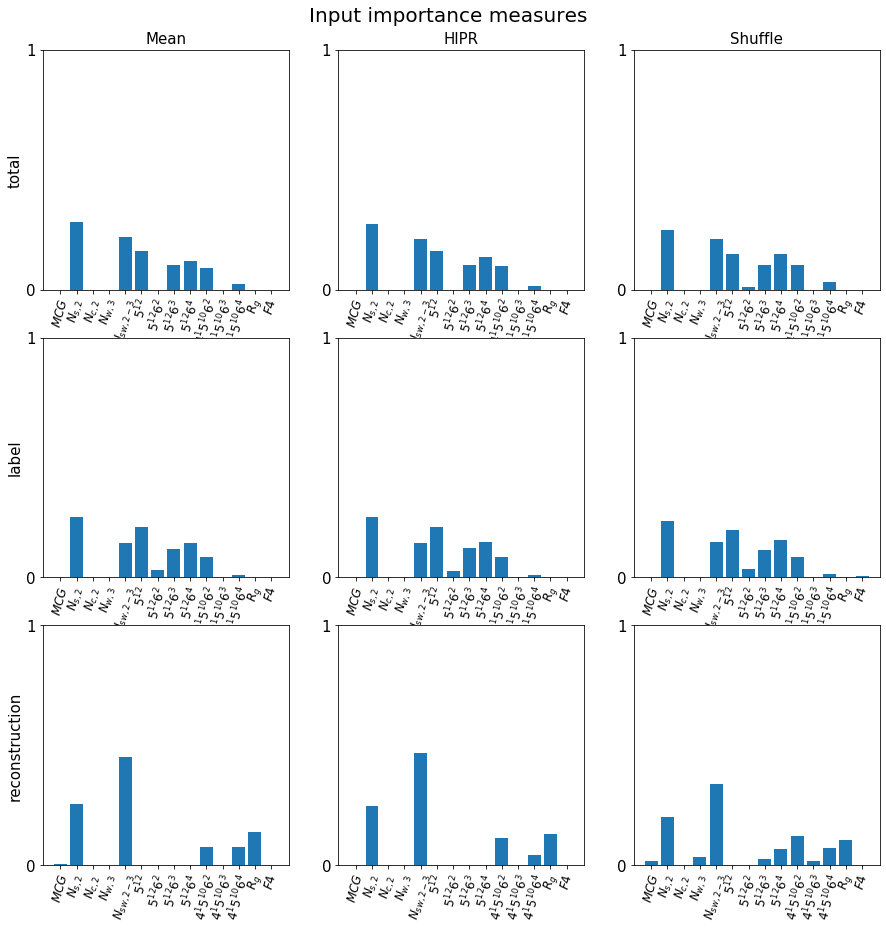

In [16]:
val_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: dataO.val_norm_past_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_labels, 
    c.output_name_2: dataO.val_norm_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_weights, 
    c.output_name_2: dataO.val_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("val_ds generated")

modes = [["Mean", None],["HIPR", [-0.9,0.9]],["Shuffle", None]]
#modes = [["Perturb", 0.5]]

impO.plot_super_importance(
    subfig_size = c.subfig_size, i_s = var_order, 
    stamp = c.stamp, var_names = var_names, 
    repetitions = 1, modes = modes,
    loss_names = c.loss_names,
    val_ds = val_ds, model = autoencoder)


In [17]:
test_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: dataO.test_norm_past_snapshots}, 
    {c.output_name_1: dataO.test_snapshot_labels, 
    c.output_name_2: dataO.test_norm_snapshots}, 
    {c.output_name_1: dataO.test_snapshot_weights, 
    c.output_name_2: dataO.test_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("test_ds generated")

test_ds generated


In [14]:
impO.reduced_set_importance([1], [2,3,4,5,6], "a", 1)

('will be set later', 'will be set later')

In [25]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(a)
t = np.transpose(a)
print(t)
n = []
for i in [0,2]:
    n.append(t[i])

print(np.transpose(n))
print(np.transpose([t[0],t[2]]))

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[1 4 7]
 [2 5 8]
 [3 6 9]]
[[1 3]
 [4 6]
 [7 9]]
[[1 3]
 [4 6]
 [7 9]]


In [79]:
print(c.stamp)
print(c.reconstruction_loss_weight)
c.loss_weights = [3,4]
print(c.loss_weights)
print(c.reconstruction_loss_weight)
print(c.stamp)

trT_reT_pT_o0_oc0.05_bn2_4*(4None+4tanh|4tanh)_pw1:10:0:0_lw1:1_e2
1
[3, 4]
4
trT_reT_pT_o0_oc0.05_bn2_4*(4None+4tanh|4tanh)_pw1:10:0:0_lw3:4_e2


In [ ]:
#VAR_NAMES = {i:ALL_VAR_NAMES[i] for i in USED_VARS}
#VAR_ORDER = [i for i in ALL_VAR_ORDER if i in USED_VARS]
#VAR_ORDER = [i for i in range(len(ALL_VAR_ORDER)) if ALL_VAR_ORDER[i] in USED_VARS]


In [ ]:
"""
VAR_NAMES = {
    0: "MCG",
    11: "N_{s,2}",
    12:"N_{s,3}",    
    15: "N_{s,4}",
    13: "N_{c,2}",
    14: "N_{c,3}",
    16: "N_{c,4}",
    3: "N_{w,2}",   
    2: "N_{w,3}",
    1: "N_{w,4}",
    5: "N_{sw,2-3}",    
    4: "N_{sw,3-4}",
    9: "5^{12}",
    8: "5^{12}6^{2}",
    17: "5^{12}6^{3}",
    18: "5^{12}6^{4}",
    19: "4^{1}5^{10}6^{2}",
    20: "4^{1}5^{10}6^{3}",
    21: "4^{1}5^{10}6^{4}",
    10: "CR",
    7: "R_g",
    6: "F4"
    }"""

"""
VAR_NAMES = {
    0: "MCG"
    1: "N_{s,2}"
    2 :"N_{s,3}"
    3: "N_{s,4}"
    4: "N_{c,2}"
    5: "N_{c,3}"
    6: "N_{c,4}"
    7: "N_{w,2}"
    8: "N_{w,3}"
    9: "N_{w,4}"
    10: "N_{sw,2-3}"
    11: "N_{sw,3-4}"
    12: "5^{12}"
    13: "5^{12}6^{2}"
    14: "5^{12}6^{3}"
    15: "5^{12}6^{4}"
    16: "4^{1}5^{10}6^{2}"
    17: "4^{1}5^{10}6^{3}"
    18: "4^{1}5^{10}6^{4}"
    19: "CR"
    20: "R_g"
    21: "F4"
    }"""
pass

In [17]:
model = autoencoder
print(model.name)
print(model.input_names)
print(model.output_names)

Autoencoder
['input_snapshots']
['label', 'reconstruction']


In [11]:
def show_batch(dataset):
    for batch, label, weights in dataset.take(1):
        for key, value in batch.items():
            print("{:20s}: {}".format(key,value.numpy()))

In [ ]:
#past, present = data.offset_path_lists(5)
#print(past[0][:10])
#print(present[0][:5])
#print(data.path_list[0])
#print(data.label_list[2])
#print(data.mc_weight_list[2])
#AA_past_snapshot_list, AB_past_snapshot_list, \
#    BA_past_snapshot_list, BB_past_snapshot_list, \
#    AA_snapshot_list, AB_snapshot_list, \
#    BA_snapshot_list, BB_snapshot_list, \
#    AA_snapshot_label_list, AB_snapshot_label_list, \
#    BA_snapshot_label_list, BB_snapshot_label_list, \
#    AA_snapshot_weight_list, AB_snapshot_weight_list, \
#    BA_snapshot_weight_list, BB_snapshot_weight_list = paths.snapshot_label_weight_lists(0,True,True,True)

In [3]:
#setter c.used_vars
bce = tf.keras.losses.BinaryCrossentropy()
bce = tf.keras.losses.CategoricalCrossentropy()
bce = tf.keras.losses.CategoricalHinge()
loss = bce([1.], [0.])
#print('Loss: ', loss.numpy())  # Loss: 11.522857
def neg_likelihood(y_actual, y_pred):
#    return -(y_actual*math.log(y_pred) + (1-y_actual)*math.log(1-y_pred))
    #print(y_actual*math.log(y_pred), (1-y_actual)*math.log(1-y_pred))
    # tf.math.log()
    return -(y_actual * tf.math.log(y_pred) + (1-y_actual) * tf.math.log(1-y_pred))
#print(likelihood_max_loss(1., 0.9999))
loss = neg_likelihood(tf.constant([1.,1.]), tf.constant([0.000000000001,0.9]))
print('Loss: ', loss.numpy())  # Loss: 11.522857

Loss:  [27.631  0.105]
